# Low volatility anamoly
## Future returns of previously low return volatility portfolios outperform those of previously high return volatility portfolio


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
from decimal import ROUND_HALF_UP, Decimal
from statsmodels.api import OLS
import random
import statsmodels.api as sm


In [7]:
train_stock_prices = pd.read_csv('ds/train_files/stock_prices.csv')
supplemental_stock_prices = pd.read_csv('ds/supplemental_files/stock_prices.csv')
data_stock_prices = pd.concat([train_stock_prices,supplemental_stock_prices],ignore_index=True)

In [8]:
def calc_adjusted_close(df):
    df = df.sort_values("Date",ascending=False)
    df.loc[:,"cummulative_adjustment_factor"] = df["AdjustmentFactor"].cumprod()
    df.loc[:,"adjusted_close"] = (df["cummulative_adjustment_factor"]*df["Close"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df = df.sort_values("Date")
    df.loc[df["adjusted_close"]==0,"adjusted_close"] = np.nan
    df.loc[:,"adjusted_close"] = df.loc[:,"adjusted_close"].ffill()
    return df

In [32]:

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        #Target is the rate of change 
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    buf.plot()
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [37]:
def create_features(df,n):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.drop(["RowId"],axis=1)
    df = df[df["Date"]!="2020-10-01"]
    df = df.groupby("SecuritiesCode").apply(calc_adjusted_close).reset_index(drop=True).sort_values(["Date","SecuritiesCode"]).reset_index(drop=True)
    #Paper uses 6 months (126 trading days) to a year (252 trading days)
    df["std"] = df.groupby("SecuritiesCode")["adjusted_close"].rolling(n).std().reset_index(0,drop=True)
    df = df.dropna(subset=["std"])
    df["Rank"]=df.groupby('Date')["std"].rank(method='first')-1
    return df

In [38]:
risk = create_features(train_stock_prices,30)


0.041541286437843314

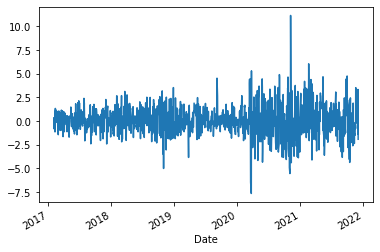

In [39]:
calc_spread_return_sharpe(risk)